# Opt

In this chapter, we will learn about **structural optimization** (also called structural relaxation, structure optimization or structure relaxation), which calculates the local stability coordinates of a system and its energy.

There are two types of optimization algorithms: global optimization and local optimization. We focus our attention on local optimization methods for structural optimization in this chapter.

<figure>
    <img src="../assets/ch2/local-global-minimum.en.png" width="720px">
    <figcaption>The horizontal axis represents the various conformations of the system, and the vertical axis represents the energy.</figcaption>
</figure>

The coordinates of a system consisting of N atoms have $3*N$ dimensions of freedom, for example, a system consisting of 100 atoms is an optimization problem in a high-dimensional space of 300 dimensions. <br/>
Finding a globally optimal solution is generally a difficult problem.

Structural optimization finds the system's stable structure by determining the system's initial coordinates and finding local stable points from there. <br/>
Even when the composition of a substance (combination of elements and their proportions, e.g., NaCl) is known, it is not apparent what its structure is.
Determining the stable structure is essential because many properties of a substance are determined from its state near its stable structure.

The following analytical and measuring instruments may be used to determine the structure experimentally.

However, even in that case

 - Only partial information on the material can be obtained from the spectral information, and information on the 3D structure cannot be directly observed (1~6)
 - It is necessary to prepare structures such as single crystals or thin films, and it is sometimes difficult to prepare such samples in reality (3, 8)
 - Lack of resolution for atomic scale observation (7)
 - Although the shape of the surface can be observed, it is not possible to distinguish the type of atoms and molecules (9)

It is not easy to determine how each atom is arranged in the material we are dealing with and to identify the three-dimensional structure of the material.

Examples of analytical instruments:

| Name | Description |
|:---|:---|
|1. Infrared spectroscopy |Obtain information on molecular structure by measuring infrared absorption due to molecular vibrations. |
|2. Raman spectroscopy |Raman scattering light is used to evaluate materials. |
|3. XRD: X-ray Diffraction |Identification and quantification of substances by analyzing diffraction obtained by a beam of incident X-rays to crystal structures. |
|4. XPS: X-ray Photoelectron Spectroscopy |X-rays are irradiated to a material, and the photoelectrons e- emitted as a result of ionization of the material are measured for energy analysis. |
|5. MS: Mass Spectroscopy |Accurately measures the mass of individual compounds that make up a substance. |
|6. NMR: Nuclear Magnetic Resonance | Analyze organic compounds using the phenomenon of nuclear resonance. |
|7. SEM: Scanning Electron Microscope | Observation of surfaces with a resolution of 0.4~4nm using electron beams with short wavelengths. |
|8. TEM: Transmission Electron Microscope | Observation of microscopic substances by the intensity of the electron beam transmitted through the object. |
|9. AFM: Atomic Force Microscope | Microscope to detect the atomic forces acting between the tip and the sample. |

Therefore, it is vital to estimate which structure is likely to be in the simulation and verify it in the experiment (or vice versa).

## Opt molecules

First, let us try to optimize the structure of a single organic molecule without periodic boundary conditions as a simple example.


### 1. Hydrogen molecule

First, we will use structural optimization to find the bond length for the most stable structure of the hydrogen molecule, 
which we did in the previous chapter.

The flow will be as follows

 - Step 1: Prepare a calculator to calculate potential energy.
 - Step 2: Prepare molecules for structural optimization.
 - Step 3: Select a method for the structural optimization algorithm and run it.

In [1]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


print(f"pfp_api_client: {pfp_api_client.__version__}")

estimator = Estimator(calc_mode=EstimatorCalcMode.MOLECULE, model_version="v3.0.0")
calculator = ASECalculator(estimator)

pfp_api_client: 1.19.0


The `calc_mode` of PFP `Estimator` is used as follows.

 - General system: `EstimatorCalcMode.CRYSTAL_U0`, mode without U parameter.
 - Oxides, etc.: `EstimatorCalcMode.CRYSTAL`, mode with U parameter.
 - Single organic molecules: `EstimatorCalcMode.MOLECULE`, molecular mode.


Step 2: Prepare molecules for structural optimization

Here we create a hydrogen molecule. We will manually set the initial coordinates at a distance of 1.0A.

In [2]:
from ase import Atoms

atoms = Atoms("H2", [[0, 0, 0], [0, 0, 1.0]])
atoms.calc = calculator

Step 3: Select and run the structural optimization algorithm method

As local optimization algorithms, ASE offers the `FIRE` and `MDMin` methods which perform optimization with gradient descent-like behavior, and the `BFGS`, `LBFGS`, `BFGSLineSearch`=`QuasiNewton`, `LBFGSLineSearch` methods which perform optimization by considering second derivertive are provided. 
The differences and properties of these algorithms are explained in the later section.

 - https://wiki.fysik.dtu.dk/ase/ase/optimize.html

This time, we will use `LBFGS` to perform structural optimization. <br/>
We will set `atoms` to the local optimization algorithm and call the `run` method to perform structural optimization. <br/>
If you specify the `trajectory` argument, you can save the structural optimization process.

In [3]:
import os
from ase.optimize import LBFGS, BFGS, FIRE

os.makedirs("output", exist_ok=True)

opt = LBFGS(atoms, trajectory="output/bfgs_h2.traj")
opt.run(fmax=0.01)

       Step     Time          Energy          fmax
LBFGS:    0 07:48:29       -3.890511        4.499346
LBFGS:    1 07:48:29       -4.402222        3.232964
LBFGS:    2 07:48:29       -3.401420       16.563093
LBFGS:    3 07:48:29       -4.551078        2.235490
LBFGS:    4 07:48:29       -4.610467        1.387879
LBFGS:    5 07:48:29       -4.641043        0.355172
LBFGS:    6 07:48:29       -4.642628        0.057615
LBFGS:    7 07:48:29       -4.642675        0.002342


True

In this simple example, the structural optimization was completed in 7 steps, and it took about 2 seconds in Matlantis.

Let's visualize the process of structural optimization.

In [4]:
from ase.visualize import view
from ase.io import Trajectory
from pfcc_extras.visualize.view import view_ngl

traj = Trajectory("output/bfgs_h2.traj")
view_ngl(traj, representations=["ball+stick"], w=400, h=300)

Plot how the atomic distances have changed during structural optimization.

In [5]:
import numpy as np

# np.linalg.norm?
distance_list = []
E_pot_list = []
for atoms in traj:
    p1, p2 = atoms.get_positions()
    distance = np.linalg.norm(p1 - p2)
    distance_list.append(distance)
    E_pot_list.append(atoms.get_potential_energy())

print("Distance trajectory", distance_list)

Distance trajectory [1.0, 0.8714472498212542, 0.5432632207735979, 0.8178503566614075, 0.7851969982523657, 0.7317303308007994, 0.7426249312804079, 0.7411043031630498]


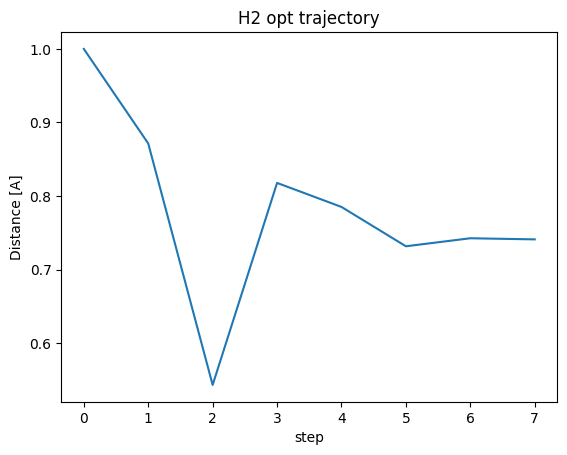

In [6]:
import matplotlib.pyplot as plt
plt.plot(distance_list)
plt.xlabel("step")
plt.ylabel("Distance [A]")
plt.title("H2 opt trajectory")
plt.show()

Finally, it settled around `0.74` A.

In the previous chapter, we calculated the energies for all bond distances and found the lowest energy value, but we can efficiently find a stable structure by using structural optimization.

### 2. Cyclohexane

As a next example, consider the stable structure of cyclohexane.

Cyclohexane has the structure C6H12, but is known to take several conformations. <br/>
Typical conformational isomers include chair (A), twist-boat (B), boat (C), and half-chair (D), as shown in the figure below.

The chair conformation is the most stable (lowest energy); at 25°C, 99.99% of all molecules in cyclohexane solution are in this conformation. <br/>
In this section, we will prepare the initial structures of the chair shape (A) and the boat shape (C), perform structural optimization, and compare their shapes and potential energies.

<figure style="width:600px">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Cyclohexane_ring_flip_and_relative_conformation_energies.svg"/>
</figure>

<cite>Cite from [cyclohexane conformation](https://en.wikipedia.org/wiki/Cyclohexane_conformation)</cite>

**Prepare initial coordinate structure**

The chair shape is prepared from the structure published in PubChem.

3D structure image of CID 8078 Cyclohexane (Compound)

PubChem Identifier: CID 8078<br/>
URL: https://pubchem.ncbi.nlm.nih.gov/compound/8078#section=3D-Conformer


In [7]:
from ase.io import read

chair_atoms = read("../input/Conformer3D_CID_8078.sdf")
view_ngl(chair_atoms, representations=["ball+stick"], w=400, h=300)

In this tutorial, let's generate the boat shape by manually changing the coordinate values from the chair shape.

You can skip understanding the code even if you don't know what it does. (We create atoms rotated 180 degrees, and only atoms 2, 10, and 11 are overwritten with the rotated coordinates.)

In [8]:
boat_atoms = chair_atoms.copy()
axis = boat_atoms.positions[[1, 5]].mean(axis=0) - boat_atoms.positions[[0, 4]].mean(axis=0)
boat_atoms.rotate(180, axis)
# inds = [1, 3, 5, 8, 9, 12, 13, 16, 17]
inds = [2, 10, 11]
boat_atoms.positions[inds] = chair_atoms.positions[inds]

In [9]:
view_ngl(boat_atoms, representations=["ball+stick"], w=400, h=300)

In [10]:
chair_atoms.calc = calculator
opt = LBFGS(chair_atoms, trajectory="output/lbfgs_cyclohexane_chair.traj")
opt.run()

       Step     Time          Energy          fmax
LBFGS:    0 07:48:41      -76.855967        0.177793
LBFGS:    1 07:48:41      -76.858236        0.115106
LBFGS:    2 07:48:41      -76.860061        0.099812
LBFGS:    3 07:48:41      -76.862499        0.049934


True

In [11]:
boat_atoms.calc = calculator
opt = LBFGS(boat_atoms, trajectory="output/lbfgs_cyclohexane_boat.traj")
opt.run()

       Step     Time          Energy          fmax
LBFGS:    0 07:48:41      -71.025782        5.364408
LBFGS:    1 07:48:41      -72.330455        4.422848
LBFGS:    2 07:48:41      -74.196689        3.282173
LBFGS:    3 07:48:41      -75.112909        4.295021
LBFGS:    4 07:48:41      -75.580792        2.727962
LBFGS:    5 07:48:41      -75.743029        2.464937
LBFGS:    6 07:48:41      -75.854446        1.896619
LBFGS:    7 07:48:41      -76.089088        0.783934
LBFGS:    8 07:48:41      -76.161671        0.672663
LBFGS:    9 07:48:42      -76.249393        0.827117
LBFGS:   10 07:48:42      -76.300563        0.745083
LBFGS:   11 07:48:42      -76.366204        0.636519
LBFGS:   12 07:48:42      -76.410981        0.546357
LBFGS:   13 07:48:42      -76.432974        0.240706
LBFGS:   14 07:48:42      -76.442169        0.239477
LBFGS:   15 07:48:42      -76.450886        0.213438
LBFGS:   16 07:48:42      -76.458270        0.177247
LBFGS:   17 07:48:42      -76.462887        0.19

True

Visualize and check the structure after structural optimization.

In [12]:
view_ngl([chair_atoms, boat_atoms], representations=["ball+stick"], w=400, h=300, replace_structure=True)

Also, compare the energy difference between them.

The unit of energy is eV, but you can use the `units` module to convert units.

 - https://wiki.fysik.dtu.dk/ase/ase/units.html

In [13]:
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal

E_chair = chair_atoms.get_potential_energy()
E_boat = boat_atoms.get_potential_energy()

E_diff = E_boat - E_chair

print(f"E_chair {E_chair:.2f} eV")
print(f"E_boat  {E_boat:.2f} eV")
print(f"E_diff  {E_diff:.2f} eV = {E_diff / (kJ/mol):.2f} kJ/mol")

E_chair -76.86 eV
E_boat  -76.56 eV
E_diff  0.30 eV = 28.78 kJ/mol


The chair shape was found to be lower energy and more stable than the boat shape. <br/>
The energy difference was also close to the 25 kJ/mol value shown in the figure above.

Thus, in structural optimization, the initial structure is important to find the local stability point. <br/>
Even for the same cyclohexane, the results after structural optimization will differ depending on how the initial structure is prepared.

## Opt Crystals

Next, let us try to perform structural optimization for systems with periodic structures. <br/>
In the above example of an organic molecule without periodic structure, only the coordinates of each atom were subject to be optimized, but in a periodic system, the **cell size** is also subject to be optimized.

In addition, for a crystal system with periodic structure (bulk), the energy depends on the crystal structure (e.g., BCC, FCC).

### 1. Si crystal

Let us investigate what kind of structure is most stable as the crystal structure of Si. <br/>
As candidates for crystal structures, we try the following structures.

 - sc: Simple Cubic
 - bcc: Body Centered Cubic
 - fcc: Face Centered Cubic
 - hcp: Hexagonal Close Packed
 - diamond: Diamond structure

We calculate the energy per atom.

First, the following code calculates the potential energy and density for various values of the lattice constant `a` for the Si BCC structure.

Here, the `np.linspace` method is used to generate five lattice constants `a` between 2.5A and 7.0A, and the energy at each lattice constant is calculated.

In [14]:
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)

In [15]:
from ase.build import bulk


a_array = np.linspace(2.5, 7.0, 5)

bcc_energy_list = []
bcc_density_list = []
for a in a_array:
    atoms = bulk("Si", "bcc", a=a)
    atoms.calc = calculator
    # calculate potential energy for 1 atom (eV/atom)
    E_pot = atoms.get_potential_energy() / len(atoms)
    density = len(atoms) / atoms.get_volume()
    bcc_energy_list.append(E_pot)
    bcc_density_list.append(density)
    
print("lattice a: ", list(a_array))
print("Density  : ", bcc_density_list)
print("Energy   : ", bcc_energy_list)

lattice a:  [2.5, 3.625, 4.75, 5.875, 7.0]
Density  :  [0.128, 0.04198614129320596, 0.018661612479953342, 0.009862939811024537, 0.005830903790087462]
Energy   :  [-1.1319098730341466, -3.338541927872517, -1.3256690169379082, -0.19462586180172498, -0.007487773713905044]


We make a method to wrap above procedure so that we can perform this calculations on a variety of structures.

In [16]:
from ase.build import bulk

def calc_density_energy(calculator, symbol: str = "Fe", crystalstructure: str = "bcc"):
    a_array = np.linspace(2.0, 8.0, 30)

    energy_list = []
    density_list = []
    for a in a_array:
        atoms = bulk(symbol, crystalstructure, a=a)
        atoms.calc = calculator
        E_pot = atoms.get_potential_energy() / len(atoms)
        density = len(atoms) / atoms.get_volume()
        energy_list.append(E_pot)
        density_list.append(density)
    return np.array(energy_list), np.array(density_list)

This `calc_density_energy` method can be used to obtain a list of energies and densities for various structures.

In [17]:
bcc_energy, bcc_density = calc_density_energy(calculator, "Si", "bcc")
fcc_energy, fcc_density = calc_density_energy(calculator, "Si", "fcc")
sc_energy, sc_density = calc_density_energy(calculator, "Si", "sc")
hcp_energy, hcp_density = calc_density_energy(calculator, "Si", "hcp")
diamond_energy, diamond_density = calc_density_energy(calculator, "Si", "diamond")

Looking at the calculated energy values, we can see that the energy values are unstable when the value of `a` is too small (when the density is made unrealistically large).

In [18]:
bcc_energy

array([-1.51431809e+03,  1.90312667e+02,  1.00882859e+00, -2.69269451e+00,
       -3.69642231e+00, -4.01363417e+00, -3.93359445e+00, -3.67273136e+00,
       -3.28083577e+00, -2.88532223e+00, -2.49506159e+00, -2.09706337e+00,
       -1.72758789e+00, -1.41201206e+00, -1.11850796e+00, -8.32015631e-01,
       -5.81543199e-01, -3.93798775e-01, -2.63483515e-01, -1.65962399e-01,
       -9.01756211e-02, -5.25506595e-02, -4.20467020e-02, -3.06422306e-02,
       -7.48777371e-03, -7.48777371e-03, -7.48777371e-03, -7.48777371e-03,
       -7.48777371e-03, -7.48777371e-03])

The following plots avoid such values.

Using the `np.where` method, indices with absolute values of 5 or less are taken as `inds`, and plotted by `a_array[inds]` excluding the outlier values.

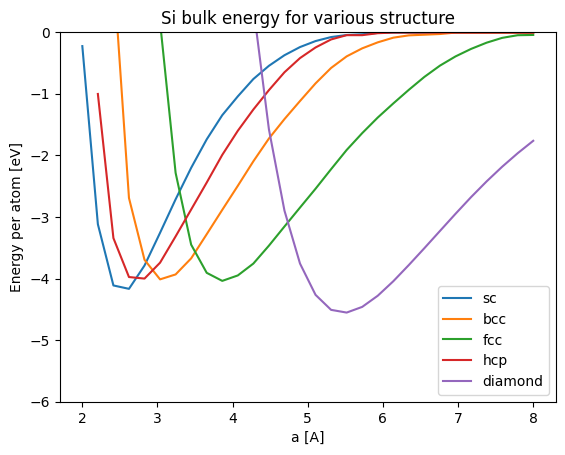

In [19]:
a_array = np.linspace(2.0, 8.0, 30)
inds = np.where(np.abs(sc_energy) < 5.0)[0]
plt.plot(a_array[inds], sc_energy[inds], label="sc")
inds = np.where(np.abs(bcc_energy) < 5.0)[0]
plt.plot(a_array[inds], bcc_energy[inds], label="bcc")
inds = np.where(np.abs(fcc_energy) < 5.0)[0]
plt.plot(a_array[inds], fcc_energy[inds], label="fcc")
inds = np.where(np.abs(hcp_energy) < 5.0)[0]
plt.plot(a_array[inds], hcp_energy[inds], label="hcp")
inds = np.where(np.abs(diamond_energy) < 5.0)[0]
plt.plot(a_array[inds], diamond_energy[inds], label="diamond")

plt.xlabel("a [A]")
plt.ylabel("Energy per atom [eV]")
plt.legend()
plt.title("Si bulk energy for various structure")

plt.ylim(-6.0, 0)
#plt.yscale("log")
plt.show()

The above figure shows the lattice constant `a` as the horizonal axis. But it is difficult to compare because the position at which the energy becomes small differs from structure to structure.

In the figure below, we plot the energy with density on the horizontal axis.

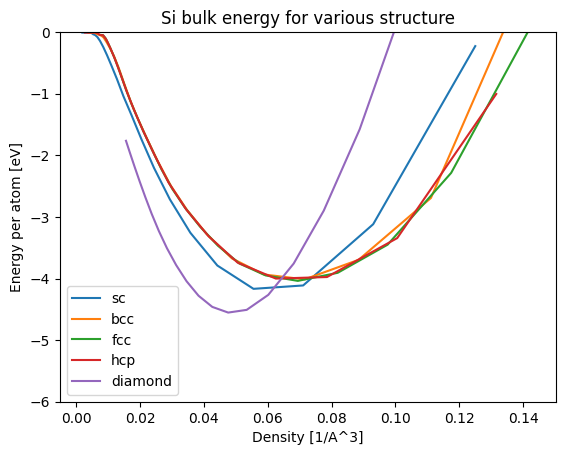

In [20]:
inds = np.where(np.abs(sc_energy) < 5.0)[0]
plt.plot(sc_density[inds], sc_energy[inds], label="sc")
inds = np.where(np.abs(bcc_energy) < 5.0)[0]
plt.plot(bcc_density[inds], bcc_energy[inds], label="bcc")
inds = np.where(np.abs(fcc_energy) < 5.0)[0]
plt.plot(fcc_density[inds], fcc_energy[inds], label="fcc")
inds = np.where(np.abs(hcp_energy) < 5.0)[0]
plt.plot(hcp_density[inds], hcp_energy[inds], label="hcp")
inds = np.where(np.abs(diamond_energy) < 5.0)[0]
plt.plot(diamond_density[inds], diamond_energy[inds], label="diamond")

plt.xlabel("Density [1/A^3]")
plt.ylabel("Energy per atom [eV]")
plt.legend()
plt.title("Si bulk energy for various structure")

plt.ylim(-6.0, 0)
#plt.yscale("log")
plt.show()

Now the figure is easier to read by taking density on the horizontal axis.

Thus, we can obtain the lattice constants likely to minimize the energy for each of the SC, BCC, FCC, HCP, and Diamond structures by performing calculations with different lattice constants. <br/>
By comparing the minimum energies for each structure in this calculation, we can analyze that **the diamond structure is stable for Si**.

### 2. Lattice constant optimization of Fe crystal

Next, let's find this lattice constant efficiently by using a structural optimization algorithm.
When optimizing a bulk with a periodic structure, the method differs depending on whether we are optimizing only the atomic coordinates or **including the cell size**. <br/>
If you want to optimize the cell as well, you need to apply the following Filter class to the ASE atoms.

**Table: Optimization target and Filter to be used**

|  Position  | Cell | Filter |
| ---- | ---- | ---- |
|  ✓  |    | No filter (Default behavior) |
|    |  ✓  | `StrainFilter` |
|  ✓  |  ✓  | `ExpCellFilter` or `UnitCellFilter` |

1. Fix atomic coordinates, opt only cell --> `StrainFilter`
2. Fix cell, opt only atomic coordinates --> No Filter
3. Opt both atomic coordinates and cell  --> `ExpCellFilter`


Here is an example of using `StrainFilter`.

We will optimize the lattice constants of the BCC and FCC structures of Fe atoms. <br/>
Since the BCC and FCC structures contain only one atom in the primitive cell, optimizing the atomic coordinates is not necessary, and it is sufficient to optimize only the lattice constants. 
So `StrainFilter` is appropriate.

In [21]:
from ase.constraints import ExpCellFilter, StrainFilter

fe_bcc_atoms = bulk("Fe", "bcc", a=3.0)
print("Before opt:", fe_bcc_atoms.cell)
fe_bcc_atoms.calc = calculator

fe_bcc_atoms = StrainFilter(fe_bcc_atoms)
opt = LBFGS(fe_bcc_atoms, trajectory="output/lbfgs_fe_bcc.traj")
opt.run()

Before opt: Cell([[-1.5, 1.5, 1.5], [1.5, -1.5, 1.5], [1.5, 1.5, -1.5]])
       Step     Time          Energy          fmax
LBFGS:    0 07:49:00       -4.865733        2.255798
LBFGS:    1 07:49:00       -4.933621        2.070161


/tmp/ipykernel_8263/2757688531.py:7: FutureWarning: Import StrainFilter from ase.filters
  fe_bcc_atoms = StrainFilter(fe_bcc_atoms)


LBFGS:    2 07:49:00       -4.434307        8.054118
LBFGS:    3 07:49:00       -4.992680        0.574830
LBFGS:    4 07:49:00       -4.996655        0.145940
LBFGS:    5 07:49:00       -4.996942        0.005053


True

In [22]:
from ase.constraints import ExpCellFilter, StrainFilter

fe_fcc_atoms = bulk("Fe", "fcc", a=3.0)
print("Before opt:", fe_fcc_atoms.cell)
fe_fcc_atoms.calc = calculator

fe_fcc_atoms = StrainFilter(fe_fcc_atoms)
opt = LBFGS(fe_fcc_atoms, trajectory="output/lbfgs_si_fcc.traj")
opt.run()

Before opt: Cell([[0.0, 1.5, 1.5], [1.5, 0.0, 1.5], [1.5, 1.5, 0.0]])
       Step     Time          Energy          fmax
LBFGS:    0 07:49:00       -2.789321       16.496249
LBFGS:    1 07:49:00       -4.806753        3.013051


/tmp/ipykernel_8263/4073470097.py:7: FutureWarning: Import StrainFilter from ase.filters
  fe_fcc_atoms = StrainFilter(fe_fcc_atoms)


LBFGS:    2 07:49:00       -4.878338        0.692597
LBFGS:    3 07:49:00       -4.882888        0.107131
LBFGS:    4 07:49:01       -4.883018        0.013641


True

In [23]:
fe_bcc_atoms.atoms.cell

Cell([[-1.424373220802055, 1.4243732323566523, 1.4243732224391294], [1.4243732433851983, -1.424373243180149, 1.4243732558457693], [1.4243732426609599, 1.424373265039054, -1.4243732332626262]])

In [24]:
fe_fcc_atoms.atoms.cell

Cell([[1.194992256261704e-08, 1.72557732778147, 1.725577359854295], [1.7255772746462514, 3.488599100910474e-08, 1.7255773369182266], [1.7255772981193618, 1.7255773283185123, 1.1412880607306823e-08]])

When optimizing the lattice constants using `StrainFilter`, the values of the a, b, and c axes are slightly different because of the lack of consideration for the symmetry of the crystal. <br/>
(In fact, it is possible to optimize while preserving the symmetry by using `ExpCellFilter` or `FixSymmetry` as described below.)

Here we will take the average value to calculate the final lattice constant. <br/>
For the argument `a` to the `bulk` method of ASE, the cells of the BCC structure are

```
[[-a/2, a/2, a/2],
 [a/2, -a/2, a/2],
 [a/2, a/2, -a/2]]
```

The cells of the FCC structure are

```
[[0, a/2, a/2],
 [a/2, 0, a/2],
 [a/2, a/2, 0]]
```

The following calculation is performed using this fact.

In [25]:
a = np.abs(fe_bcc_atoms.atoms.cell).mean() * 2
E_pot = fe_bcc_atoms.get_potential_energy()
print(f"BCC opt: a = {a:.2f} A, E = {E_pot:.2f} eV")

a = fe_fcc_atoms.atoms.cell.sum() / 3
E_pot = fe_fcc_atoms.get_potential_energy()
print(f"FCC opt: a = {a:.2f} A, E = {E_pot:.2f} eV")

BCC opt: a = 2.85 A, E = -5.00 eV
FCC opt: a = 3.45 A, E = -4.88 eV


As a result of structural optimization, we found that the BCC structure has the minimum energy at `a=2.85` A.

We also found that **Fe is more stable in the BCC structure than in the FCC structure**, which is consistent with experimental results.

Visualization of the progress of structural optimization shows that only the lattice constants are optimized, while the atomic coordinates remain the same.

In [26]:
view_ngl(Trajectory("output/lbfgs_fe_bcc.traj"), w=400, h=300, replace_structure=True)

One caveat to using `StrainFilter` is that the a, b, and c axes of a cell are optimized independently, so even if you want to keep that ratio, it may not be preserved.

### 3. Lattice constant optimization of Si crystal diamond structure

Next, let us perform optimization for the Si crystal diamond structure. <br/>
Here, we use `ExpCellFilter` to optimize both atomic coordinates and cell size.

In `ExpCellFilter`, you can perform optimization while preserving the ratio of a, b, and c axis lengths of cells by setting `hydrostatic_strain=True`.

In [27]:
from ase.constraints import ExpCellFilter, StrainFilter

si_diamond_atoms = bulk("Si", "diamond")
si_diamond_atoms.calc = calculator

print("cell size before: ", si_diamond_atoms.cell)
si_diamond_atoms = ExpCellFilter(si_diamond_atoms, hydrostatic_strain=True)
opt = LBFGS(si_diamond_atoms, trajectory="output/lbfgs_si_diamond.traj")
opt.run()

print("cell size after : ", si_diamond_atoms.atoms.cell)

cell size before:  Cell([[0.0, 2.715, 2.715], [2.715, 0.0, 2.715], [2.715, 2.715, 0.0]])
       Step     Time          Energy          fmax
LBFGS:    0 07:49:01       -9.108033        0.496673


/tmp/ipykernel_8263/1308828941.py:7: FutureWarning: Import ExpCellFilter from ase.filters
  si_diamond_atoms = ExpCellFilter(si_diamond_atoms, hydrostatic_strain=True)


LBFGS:    1 07:49:01       -9.113255        0.001952
cell size after :  Cell([[0.0, 2.7342638237564514, 2.7342638237564514], [2.7342638237564514, 0.0, 2.7342638237564514], [2.7342638237564514, 2.7342638237564514, 0.0]])


Comparing the before and after of cell size, we can see that the cell size ratio was maintained during the structural relaxation.

In [28]:
view_ngl(Trajectory("output/lbfgs_si_diamond.traj"), w=400, h=300, replace_structure=True)

### 4. SiO$_2$ crystal

So far, we have dealt with crystals containing only one element. Finally, we will optimize for SiO$_2$ crystals as a more practical example.

SiO2 is also known to take various structures such as [Quartz](https://en.wikipedia.org/wiki/Quartz), [Cristobalite](https://en.wikipedia.org/wiki/Cristobalite), and [Tridymite](https://en.wikipedia.org/wiki/Tridymite) in reality.
The existence of many crystal systems with the same composition is called [polymorphism](https://en.wikipedia.org/wiki/Polymorphism_(materials_science)).

In this case, the Quartz structure is prepared from the Materials project, and structural optimization is performed.
An `ExpCellFilter` is used to optimize both coordinates and cell size at the same time.

Input cif file is from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

In [29]:
atoms = read("../input/SiO2_mp-6930_conventional_standard.cif")
atoms.calc = calculator

view_ngl(atoms, representations=["ball+stick"])

In [30]:
opt = LBFGS(ExpCellFilter(atoms), trajectory="output/lbfgs_sio2.traj")
opt.run()

       Step     Time          Energy          fmax
LBFGS:    0 07:49:01      -57.136951        0.037918


/tmp/ipykernel_8263/3624119703.py:1: FutureWarning: Import ExpCellFilter from ase.filters
  opt = LBFGS(ExpCellFilter(atoms), trajectory="output/lbfgs_sio2.traj")


True

In [31]:
view_ngl(Trajectory("output/lbfgs_sio2.traj"), representations=["ball+stick"])

**[Note] Structural optimization is required every time Calculator (potential energy) changes**

You might think that the structure of the Materials project is already a perfectly stable structure, since it is also a structure that has undergone structural optimization.
However, the exact local point (the structure that takes the lowest energy) is different when the potential energy changes.

## [Column] Structural optimization and the real world

The structural optimization calculations presented in this chapter are the foundation for almost all the atomistic simulations introduced later. However, the computational methods used inside the structural optimization are somewhat technical, and those new to atomistic simulations through this tutorial may not intuitively understand the necessity of such calculations. Therefore, in this column, we will review structural optimization calculations from the viewpoint of their correspondence with the real world.

### Need for structural optimization

Considering how the atomic arrangement of material in the real world is determined, each atom is free to move around without any particular constraints, so excess energy is dissipated and transformed into a stable structure with low energy. 
Once we consider the case where the temperature is sufficiently low, ignoring the effect of temperature, in that case, the kinetic energy of the atoms will be zero, and the potential energy will be minimal. 
In this sense, structural optimization calculations correspond to absolute zero temperature conditions in the real world.

What about the case of finite temperature? 
From the theory of statistical mechanics, it is known that temperature and kinetic energy have a constant relationship in a system in equilibrium. A rough calculation shows that a 1 K rise corresponds roughly to a 1/10000 eV/atom increase in kinetic energy. 
Conversely, an increase in energy of 1 eV/atom corresponds to a structure of about 10000 K in terms of temperature. 
Thus, even at finite temperatures, an energy-optimized structure is often a good enough approximation, so it is common practice to start the simulation with a structural optimization calculation (and then increase the temperature for finite temperatures).

Simulations without structural optimization may lead to unrealistic results due to differences in assumptions. 
For example, if the cell size of the iron crystal structure is reduced by 1%, you may not notice any particular change if you only visualize the atomic structure. 
However, as can be seen by considering the operation of shrinking iron by 1% in the real world, this corresponds to iron under high compressive force (specifically, pressure in excess of 1 GPa), which can change the results of the simulation.

### Structural optimization methods and real world structural relaxation

Let us consider why there are several structural optimization methods by their correspondence to the real world. What happens when the material at an appropriately high temperature, like molten iron, is cooled slightly by removing heat? The iron atoms constantly vibrate due to the heat, taking on various atomic configurations and gradually transitioning to a structure with lower potential energy. Eventually, they transition to a crystal structure with low energy, a well-ordered atomic arrangement. In this sense, structural optimization in the real world is considered [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)). 
(Historically, this corresponds to the original idea of annealing.)

In simulated annealing, atoms are in motion for a long time at an elevated temperature. It means that, in principle, an atomistic simulation can yield the same stable structure as in the real world if a sufficiently long molecular dynamics calculation can be performed.

The problem here, however, is the gap between the time scale of the MD simulation and reality. 
While atomic motion is typically a femtosecond ($10^{-15}$ s) order phenomenon, much longer time scales typically come into play when considering real-world materials. 
Therefore, real-world structures can be viewed as the result of extremely long-time structural optimization calculations on the scale of $10^{15}$ or even longer atomic scale simulations.
It is also known that the annealing method is a highly robust optimization technique and can arrive at a more globally optimal solution by taking a sufficiently long time. 
Therefore, it is possible to consider that a material that exists, in reality, has obtained an atomic structure for which the global optimization problem has been virtually solved.

Thus, methods that allow atomistic simulations to find more globally optimal solutions in a shorter time have been developed. This is generally a tradeoff against computational time and is used in different cases. Suppose the structure of interest is already known, such as a crystalline structure, and a sufficiently close structure can be taken as the initial structure. In that case, the BFGS-like method shown in the example above is the preferred method for finding the local optimum. Conversely, when the target structure is unknown, such as an amorphous structure, more attention is paid to finding a more globally optimal solution. (For more realistic results, melt-quench methods are used, for example, in which the temperature is slowly lowered.) This is why libraries of atomic simulations, including ASE, include a variety of optimal solution methods.
As a side note, there are cases in the real world where the solution is not globally optimal. For example, diamond, a high-pressure phase of carbon, is not stable on earth, and graphite is the most stable allotrope. Because of the high energy required for structural change, the rate of structural change is extremely slow and is treated as a practically stable structure ([metastable state](https://en.wikipedia.org/wiki/Metastability)) on the human time scale. 

A famous example of active use in manufacturing is the quenching of iron. The technique of hardening heated iron by immersing it in water is well known in the forging of Japanese swords. The time required for structural relaxation is limited by rapidly quenching the temperature, and the transition to a stable structure is prevented. This treatment yields a metastable state with a more desirable strength.

Thus, phenomena involving phase transformations and chemical changes often occur slowly, even on an everyday scale. This is true for atomistic simulations as well, and if one wants to look at phase transformations or chemical reactions, a more efficient computational approach may be used than simply performing long kinetic calculations. One specific example is the NEB method described in chapter 5.